In [1]:
import tensorflow as tf
from IPython.display import Image, display

import matplotlib.pyplot as plt
import tensorflow_hub as hub

import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
!nvidia-smi

Sun Jun 20 18:17:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

--2021-06-20 18:17:32--  https://storage.googleapis.com/ibeans/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.33.208, 172.217.9.208, 172.217.12.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.33.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M   116MB/s    in 1.2s    

2021-06-20 18:17:33 (116 MB/s) - ‘train.zip’ saved [143812152/143812152]

--2021-06-20 18:17:33--  https://storage.googleapis.com/ibeans/validation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[==================

In [4]:
!mkdir beans

In [5]:
!unzip train.zip -d beans/
!unzip test.zip -d beans/
!unzip validation.zip -d beans/


Archive:  train.zip
   creating: beans/train/
   creating: beans/train/healthy/
   creating: beans/train/angular_leaf_spot/
   creating: beans/train/bean_rust/
  inflating: beans/train/healthy/healthy_train.265.jpg  
  inflating: beans/train/healthy/healthy_train.271.jpg  
  inflating: beans/train/healthy/healthy_train.259.jpg  
  inflating: beans/train/healthy/healthy_train.99.jpg  
  inflating: beans/train/healthy/healthy_train.311.jpg  
  inflating: beans/train/healthy/healthy_train.66.jpg  
  inflating: beans/train/healthy/healthy_train.72.jpg  
  inflating: beans/train/healthy/healthy_train.305.jpg  
  inflating: beans/train/healthy/healthy_train.339.jpg  
  inflating: beans/train/healthy/healthy_train.113.jpg  
  inflating: beans/train/healthy/healthy_train.107.jpg  
  inflating: beans/train/healthy/healthy_train.106.jpg  
  inflating: beans/train/healthy/healthy_train.112.jpg  
  inflating: beans/train/healthy/healthy_train.338.jpg  
  inflating: beans/train/healthy/healthy_trai

In [6]:
!ls beans

test  train  validation


In [7]:
!find beans -type f | wc -l

1296


In [8]:
!find beans/test -type f | wc -l

128


In [9]:
!find beans/validation -type f | wc -l

133


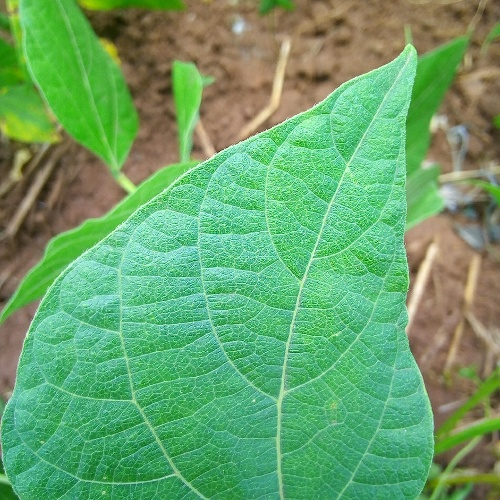

In [10]:
display(Image('beans/train/healthy/healthy_train.0.jpg'))

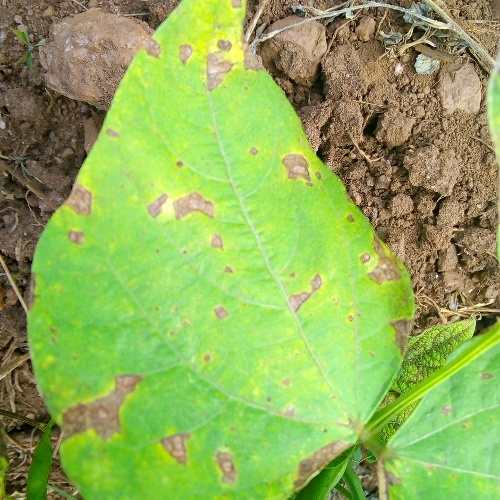

In [ ]:
display(Image('beans/train/angular_leaf_spot/angular_leaf_spot_train.124.jpg'))

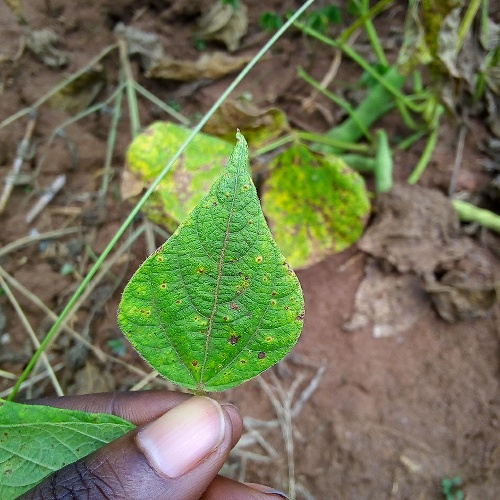

In [ ]:
display(Image('beans/train/bean_rust/bean_rust_train.162.jpg'))

In [8]:
batch_size = 128
img_height = 224
img_width = 224

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/train',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1034 files belonging to 3 classes.


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/test',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 128 files belonging to 3 classes.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/validation',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 133 files belonging to 3 classes.


In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [13]:
classes=train_ds.class_names
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


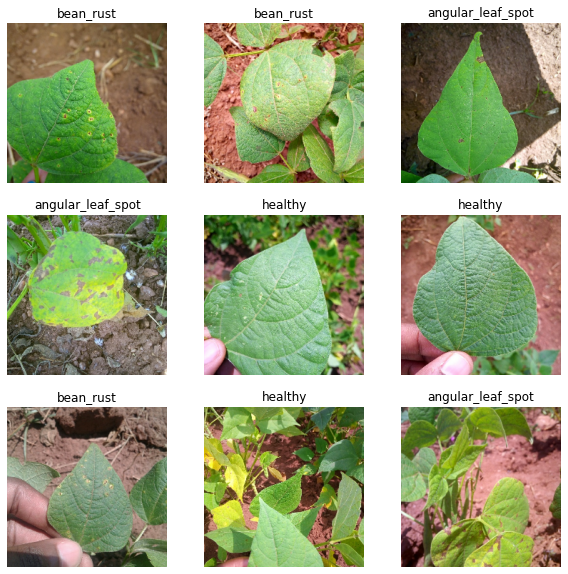

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [17]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(img_height,img_width,3))

In [18]:
feature_extractor_layer.trainable = False

In [20]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [22]:
tf.random.set_seed(111)

In [23]:
model = tf.keras.Sequential([
  normalization_layer,
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(3,activation='softmax')
])

In [24]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [25]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
9/9 [==============================] - 38s 312ms/step - loss: 1.1665 - accuracy: 0.4294 - val_loss: 0.7810 - val_accuracy: 0.6842
Epoch 2/20
9/9 [==============================] - 1s 148ms/step - loss: 0.7853 - accuracy: 0.6441 - val_loss: 0.6034 - val_accuracy: 0.7594
Epoch 3/20
9/9 [==============================] - 1s 149ms/step - loss: 0.6416 - accuracy: 0.7350 - val_loss: 0.5262 - val_accuracy: 0.7594
Epoch 4/20
9/9 [==============================] - 1s 149ms/step - loss: 0.5462 - accuracy: 0.7669 - val_loss: 0.4724 - val_accuracy: 0.7744
Epoch 5/20
9/9 [==============================] - 1s 149ms/step - loss: 0.4918 - accuracy: 0.8037 - val_loss: 0.4385 - val_accuracy: 0.7895
Epoch 6/20
9/9 [==============================] - 1s 149ms/step - loss: 0.4597 - accuracy: 0.8153 - val_loss: 0.4079 - val_accuracy: 0.8045
Epoch 7/20
9/9 [==============================] - 1s 149ms/step - loss: 0.4212 - accuracy: 0.8317 - val_loss: 0.3875 - val_accuracy: 0.8421
Epoch 8/20
9/9 [===

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


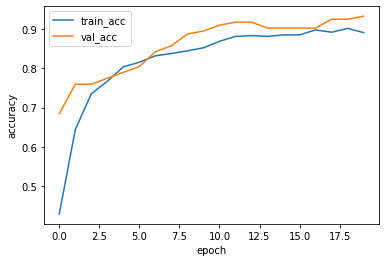

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='best')
plt.show()

In [29]:
result=model.evaluate(test_ds)

1/1 [==============================] - 0s 457ms/step - loss: 0.2727 - accuracy: 0.8906


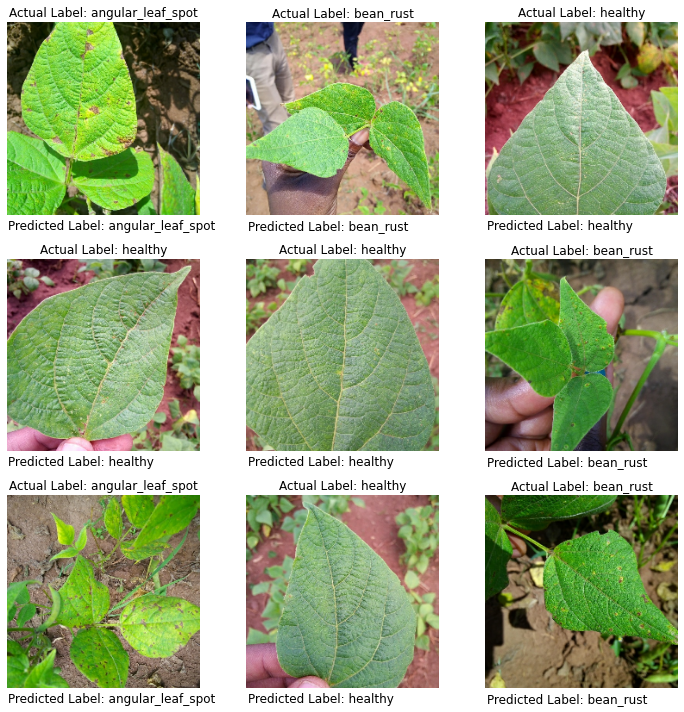

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    plt.tight_layout()
    
    img = tf.keras.preprocessing.image.img_to_array(images[i])                    
    img = np.expand_dims(img, axis=0)  

    pred=model.predict(img)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual Label: %s" % classes[labels[i]])
    plt.text(1, 240, "Predicted Label: %s" % classes[np.argmax(pred)], fontsize=12)

    plt.axis("off")

In [31]:
model.save('./models', save_format='tf')

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [32]:
!ls -alrt models

total 2052
drwxr-xr-x 1 root root    4096 Jun 20 18:32 ..
drwxr-xr-x 2 root root    4096 Jun 20 18:32 variables
drwxr-xr-x 2 root root    4096 Jun 20 18:32 assets
-rw-r--r-- 1 root root 2074577 Jun 20 18:32 saved_model.pb
-rw-r--r-- 1 root root    6631 Jun 20 18:32 keras_metadata.pb
drwxr-xr-x 4 root root    4096 Jun 20 18:32 .


In [33]:
model_loaded = tf.keras.models.load_model('./models/')

In [34]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [35]:
from PIL import Image
import numpy as np
from skimage import transform
def process(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [36]:
pred_label=model_loaded.predict(process('beans/train/healthy/healthy_train.0.jpg'))
print(classes[np.argmax(pred_label)])

healthy


In [37]:
pred_label

array([[0.00100766, 0.04009298, 0.9588994 ]], dtype=float32)

In [38]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/saved_model.pb (deflated 92%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.index (deflated 78%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/keras_metadata.pb (deflated 81%)
  adding: models/assets/ (stored 0%)


In [ ]:
print(tf.__version__)

2.5.0
